In [1]:
import pandas as pd
import numpy as np
import preprocessing as pre
import time
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

c:\users\kasia\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 3rd term: 1997 - 2001

In [32]:
k = 3
xml_file_path = '.\Sejm-20240316T162344Z-001\Sejm\GLO3k1p119p_i\GLO3k1p119p_i.xml'
csv_file = 'data\GLO3k1p119p_i.csv'

In [33]:
t1 = time.time()
df_all = pre.save_xml_as_csv(xml_file_path, csv_file)
t2 = time.time()

In [34]:
print(f'{(t2 - t1)/60:.2f} min')

1.84 min


In [35]:
df_all.head()

,vote_id,data_godzina,Nrleg,NazwiskoImie,Glos,Klub
0,3001001,1997-10-20 12:51:54,1,Adamczyk Franciszek,Za,AWS
1,3001001,1997-10-20 12:51:54,2,Adamska-Wedler Elżbieta,Za,AWS
2,3001001,1997-10-20 12:51:54,3,Adamski Władysław,Za,SLD
3,3001001,1997-10-20 12:51:54,4,Ajchler Romuald,Za,SLD
4,3001001,1997-10-20 12:51:54,5,Anusz Andrzej,Za,AWS


In [36]:
assert np.all(df_all.dtypes.values == [np.dtype('int32'), np.dtype('<M8[ns]'), np.dtype('int32'), np.dtype('O'), np.dtype('O'), np.dtype('O')])
assert df_all.isnull().sum().sum() == 0
assert df_all[df_all.duplicated()].size == 0

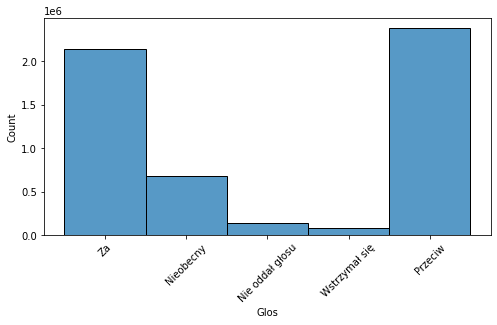

In [37]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df_all, x='Glos', discrete=True)
plt.xticks(rotation=45)
plt.show()

In [38]:
df_all['data_godzina'].min(), df_all['data_godzina'].max()

(Timestamp('1997-10-20 12:51:54'), Timestamp('2001-09-18 16:26:05'))

In [39]:
y_m_list = pd.date_range(df_all['data_godzina'].min(), df_all['data_godzina'].max(), 
              freq='M').strftime("%Y-%m").tolist()

y_m_list.append(df_all['data_godzina'].max().strftime("%Y-%m"))

In [40]:
y_m_list[0], y_m_list[-1]

('1997-10', '2001-09')

In [41]:
y_m_list = [x.split('-') for x in y_m_list]

In [42]:
t1 = time.time()
df_deputies = pre.assign_node_ids(df_all)
t2 = time.time()

In [43]:
print(f'{(t2 - t1)/60:.2f} min')

0.93 min


### Monthly grahps

In [14]:
for year, month in y_m_list:
    df_m = df_all[(df_all['data_godzina'].dt.month == int(month)) & (df_all['data_godzina'].dt.year == int(year))]
    
    if len(df_m) == 0:
        print(year, month, 'no votings')
        continue
    
    df_m = pd.merge(df_m[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_m)
    df_node_atr.to_csv(f'df_node_atr/monthly/G_{k}_{year}_{month}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_m)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}_{year}_{month}", monthly=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 20.98it/s]


252 G_3_1998_08


100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [00:11<00:00, 13.43it/s]


1999 08 no votings


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:09<00:00, 12.42it/s]


441 G_3_2000_02


100%|████████████████████████████████████████████████████████████████████████████████| 301/301 [00:30<00:00, 10.03it/s]


2000 08 no votings


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:20<00:00, 11.94it/s]


In [15]:
t3 = time.time()

In [16]:
print(f'{(t3 - t2)/60:.2f} min')

25.53 min


### 4 years graph - whole tenure

In [17]:
df_all = pd.merge(df_all, df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
df_node_atr = pre.assign_attributes(df_all)
df_node_atr.to_csv(f'df_node_atr/G_{k}.csv', index=False)

edge_matrix = pre.egde_weights(df_all)

pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}", monthly=False)
t4 = time.time()

100%|██████████████████████████████████████████████████████████████████████████| 11801/11801 [5:32:15<00:00,  1.69s/it]


In [18]:
print(f'{(t4 - t3)/60:.2f} min')

332.41 min


In [19]:
print(f'{(t4 - t3)/60/60:.2f} h')

5.54 h


### Yearly graphs

In [44]:
start = df_all['data_godzina'].min()
end_1 = pd.date_range(start=df_all['data_godzina'].min(), periods=12, freq='M')[-1]
end_2 = pd.date_range(start=end_1, periods=13, freq='M')[-1]
end_3 = pd.date_range(start=end_2, periods=13, freq='M')[-1]
end_4 = df_all['data_godzina'].max()

start_end_dates = [start, end_1, end_2, end_3, end_4]

In [45]:
start_end_dates

[Timestamp('1997-10-20 12:51:54'),
 Timestamp('1998-09-30 12:51:54', freq='M'),
 Timestamp('1999-09-30 12:51:54', freq='M'),
 Timestamp('2000-09-30 12:51:54', freq='M'),
 Timestamp('2001-09-18 16:26:05')]

In [46]:
for i in range(1, len(start_end_dates)):
    start_dt = start_end_dates[i-1]
    end_dt = start_end_dates[i]
    df_y = df_all[(df_all['data_godzina'] >= start_dt) & (df_all['data_godzina'] < end_dt)]
    
    df_y = pd.merge(df_y[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_y)
    df_node_atr.to_csv(f'df_node_atr/yearly/G_{k}_y{i}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_y)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"yearly/G_{k}_y{i}", monthly=False)

100%|████████████████████████████████████████████████████████████████████████████| 5900/5900 [1:34:13<00:00,  1.04it/s]


In [20]:
# G = pickle.load(open('filename.pickle', 'rb')) # nx
# G = nx.read_graphml()
# G = Graph.Read_GraphML("zachary.graphml") # igraph

## 4th term: 2001 - 2005

,vote_id,data_godzina,Nrleg,NazwiskoImie,Glos,Klub
0,4001002,2001-10-19 12:29:00,1,Abgarowicz Łukasz,Za,PO
1,4001002,2001-10-19 12:29:00,2,Ajchler Romuald,Za,SLD
2,4001002,2001-10-19 12:29:00,3,Antochowski Jan,Za,SLD
3,4001002,2001-10-19 12:29:00,4,Arciszewska-Mielewczyk Dorota,Za,PO
4,4001002,2001-10-19 12:29:00,5,Aszkiełowicz Mieczysław,Za,Samoobrona


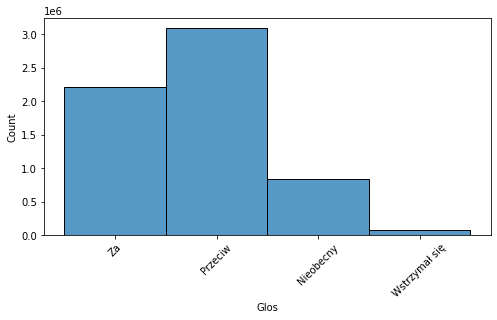

2001-10-19 12:29:00 2005-08-29 19:35:07
2001-10 2005-08
Nrleg                        468
NazwiskoImie    Zdrojewski Jacek
Klub                [SLD, niez.]
Name: 467, dtype: object


In [48]:
k = 4
xml_file_path = '.\Sejm-20240316T162344Z-001\Sejm\GLO4k1p109p_i\GLO4k1p109p_i.xml'
csv_file = 'data\GLO4k1p109p_i.csv'

df_all = pre.save_xml_as_csv(xml_file_path, csv_file)

display(df_all.head())

assert np.all(df_all.dtypes.values == [np.dtype('int32'), np.dtype('<M8[ns]'), np.dtype('int32'), np.dtype('O'), np.dtype('O'), np.dtype('O')])
assert df_all.isnull().sum().sum() == 0
assert df_all[df_all.duplicated()].size == 0

plt.figure(figsize=(8, 4))
sns.histplot(data=df_all, x='Glos', discrete=True)
plt.xticks(rotation=45)
plt.show()

print(df_all['data_godzina'].min(), df_all['data_godzina'].max())
y_m_list = pd.date_range(df_all['data_godzina'].min(), df_all['data_godzina'].max(), 
              freq='M').strftime("%Y-%m").tolist()

y_m_list.append(df_all['data_godzina'].max().strftime("%Y-%m"))
print(y_m_list[0], y_m_list[-1])
y_m_list = [x.split('-') for x in y_m_list]

# df_deputies = pre.assign_node_ids(df_all)

df_deputies = pre.create_deputy_df(df_all)
print(df_deputies.loc[467])
df_deputies.loc[467] = np.array([468, 'Zdrojewski Jacek', np.array(['SLD', 'niez.', 'UP'], dtype=object)], dtype=object)
# party doesn't match, but this is the only posibility (228 (UP) -> 468 ('SLD', 'niez.'))
    
vote_ids = sorted(df_all['vote_id'].unique())
deputy_ids_per_vote = [df_all[df_all['vote_id'] == vote_id]['Nrleg'].unique() for vote_id in vote_ids]

removed_ids, new_ids = pre.make_queues(df_deputies, vote_ids, deputy_ids_per_vote)
node_id_dict = pre.find_pairs(removed_ids, new_ids)

node_id_dict_func = lambda x: node_id_dict[x]
node_id_dict_func = np.vectorize(node_id_dict_func)

df_deputies['node_id'] = node_id_dict_func(df_deputies['Nrleg'])
df_deputies['node_id'] = df_deputies['node_id'] - 1

In [22]:
for year, month in y_m_list:
    df_m = df_all[(df_all['data_godzina'].dt.month == int(month)) & (df_all['data_godzina'].dt.year == int(year))]
    
    if len(df_m) == 0:
        print(year, month, 'no votings')
        continue
    
    df_m = pd.merge(df_m[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_m)
    df_node_atr.to_csv(f'df_node_atr/monthly/G_{k}_{year}_{month}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_m)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}_{year}_{month}", monthly=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.49it/s]


In [23]:
df_all = pd.merge(df_all, df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
df_node_atr = pre.assign_attributes(df_all)
df_node_atr.to_csv(f'df_node_atr/G_{k}.csv', index=False)

edge_matrix = pre.egde_weights(df_all)

pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}", monthly=False)

100%|██████████████████████████████████████████████████████████████████████████| 13535/13535 [7:47:56<00:00,  2.07s/it]


In [49]:
start = df_all['data_godzina'].min()
end_1 = pd.date_range(start=df_all['data_godzina'].min(), periods=12, freq='M')[-1]
end_2 = pd.date_range(start=end_1, periods=13, freq='M')[-1]
end_3 = pd.date_range(start=end_2, periods=13, freq='M')[-1]
end_4 = df_all['data_godzina'].max()

start_end_dates = [start, end_1, end_2, end_3, end_4]
print(start_end_dates)

for i in range(1, len(start_end_dates)):
    start_dt = start_end_dates[i-1]
    end_dt = start_end_dates[i]
    df_y = df_all[(df_all['data_godzina'] >= start_dt) & (df_all['data_godzina'] < end_dt)]
    
    df_y = pd.merge(df_y[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_y)
    df_node_atr.to_csv(f'df_node_atr/yearly/G_{k}_y{i}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_y)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"yearly/G_{k}_y{i}", monthly=False)

[Timestamp('2001-10-19 12:29:00'), Timestamp('2002-09-30 12:29:00', freq='M'), Timestamp('2003-09-30 12:29:00', freq='M'), Timestamp('2004-09-30 12:29:00', freq='M'), Timestamp('2005-08-29 19:35:07')]


100%|██████████████████████████████████████████████████████████████████████████████| 2989/2989 [26:37<00:00,  1.87it/s]


## 5th term: 2005 - 2007

,vote_id,data_godzina,Nrleg,NazwiskoImie,Glos,Klub
0,5001001,2005-10-19 12:26:49,1,Abgarowicz Łukasz Maria,Przeciw,PO
1,5001001,2005-10-19 12:26:49,2,Adamczyk Andrzej,Za,PiS
2,5001001,2005-10-19 12:26:49,3,Ambroziewicz Robert,Przeciw,PO
3,5001001,2005-10-19 12:26:49,4,Andrejuk Przemysław,Przeciw,LPR
4,5001001,2005-10-19 12:26:49,5,Andzel Waldemar,Za,PiS


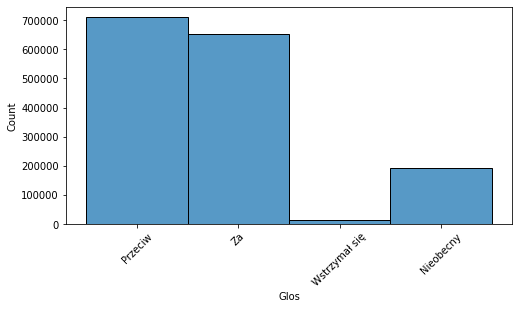

2005-10-19 12:26:49 2007-09-19 14:30:43
2005-10 2007-09


In [50]:
k = 5
xml_file_path = '.\Sejm-20240316T162344Z-001\Sejm\GLO5k1p48p_i\GLO5k1p48p_i.xml'
csv_file = 'data\GLO5k1p48p_i.csv'

df_all = pre.save_xml_as_csv(xml_file_path, csv_file)

display(df_all.head())

assert np.all(df_all.dtypes.values == [np.dtype('int32'), np.dtype('<M8[ns]'), np.dtype('int32'), np.dtype('O'), np.dtype('O'), np.dtype('O')])
assert df_all.isnull().sum().sum() == 0
assert df_all[df_all.duplicated()].size == 0

plt.figure(figsize=(8, 4))
sns.histplot(data=df_all, x='Glos', discrete=True)
plt.xticks(rotation=45)
plt.show()

print(df_all['data_godzina'].min(), df_all['data_godzina'].max())
y_m_list = pd.date_range(df_all['data_godzina'].min(), df_all['data_godzina'].max(), 
              freq='M').strftime("%Y-%m").tolist()

y_m_list.append(df_all['data_godzina'].max().strftime("%Y-%m"))
print(y_m_list[0], y_m_list[-1])
y_m_list = [x.split('-') for x in y_m_list]

df_deputies = pre.assign_node_ids(df_all)

In [25]:
for year, month in y_m_list:
    df_m = df_all[(df_all['data_godzina'].dt.month == int(month)) & (df_all['data_godzina'].dt.year == int(year))]
    
    if len(df_m) == 0:
        print(year, month, 'no votings')
        continue
    
    df_m = pd.merge(df_m[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_m)
    df_node_atr.to_csv(f'df_node_atr/monthly/G_{k}_{year}_{month}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_m)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}_{year}_{month}", monthly=True)

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:14<00:00, 11.12it/s]


In [26]:
df_all = pd.merge(df_all, df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
df_node_atr = pre.assign_attributes(df_all)
df_node_atr.to_csv(f'df_node_atr/G_{k}.csv', index=False)

edge_matrix = pre.egde_weights(df_all)

pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}", monthly=False)

100%|██████████████████████████████████████████████████████████████████████████████| 3412/3412 [41:15<00:00,  1.38it/s]


In [51]:
start = df_all['data_godzina'].min()
end_1 = pd.date_range(start=df_all['data_godzina'].min(), periods=12, freq='M')[-1]
end_4 = df_all['data_godzina'].max()

start_end_dates = [start, end_1, end_4]
print(start_end_dates)

for i in range(1, len(start_end_dates)):
    start_dt = start_end_dates[i-1]
    end_dt = start_end_dates[i]
    df_y = df_all[(df_all['data_godzina'] >= start_dt) & (df_all['data_godzina'] < end_dt)]
    
    df_y = pd.merge(df_y[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_y)
    df_node_atr.to_csv(f'df_node_atr/yearly/G_{k}_y{i}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_y)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"yearly/G_{k}_y{i}", monthly=False)

[Timestamp('2005-10-19 12:26:49'), Timestamp('2006-09-30 12:26:49', freq='M'), Timestamp('2007-09-19 14:30:43')]


100%|██████████████████████████████████████████████████████████████████████████████| 2184/2184 [20:52<00:00,  1.74it/s]


## 6th term: 2007 - 2011

,vote_id,data_godzina,Nrleg,NazwiskoImie,Glos,Klub
0,6001002,2007-11-05 19:20:54,1,Abramowicz Adam,Za,PiS
1,6001002,2007-11-05 19:20:54,2,Adamczyk Andrzej,Za,PiS
2,6001002,2007-11-05 19:20:54,3,Ajchler Romuald,Za,LiD
3,6001002,2007-11-05 19:20:54,4,Aleksandrzak Leszek,Za,LiD
4,6001002,2007-11-05 19:20:54,5,Andzel Waldemar,Za,PiS


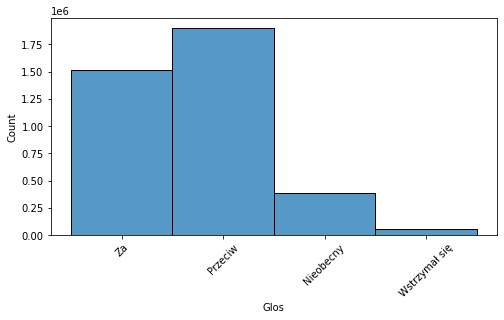

2007-11-05 19:20:54 2011-09-16 21:24:42
2007-11 2011-09


In [52]:
k = 6
xml_file_path = '.\Sejm-20240316T162344Z-001\Sejm\GLO6k1p100p_i\GLO6k1p100p_i.xml'
csv_file = 'data\GLO6k1p100p_i.csv'

df_all = pre.save_xml_as_csv(xml_file_path, csv_file)

display(df_all.head())

assert np.all(df_all.dtypes.values == [np.dtype('int32'), np.dtype('<M8[ns]'), np.dtype('int32'), np.dtype('O'), np.dtype('O'), np.dtype('O')])
assert df_all.isnull().sum().sum() == 0
assert df_all[df_all.duplicated()].size == 0

plt.figure(figsize=(8, 4))
sns.histplot(data=df_all, x='Glos', discrete=True)
plt.xticks(rotation=45)
plt.show()

print(df_all['data_godzina'].min(), df_all['data_godzina'].max())
y_m_list = pd.date_range(df_all['data_godzina'].min(), df_all['data_godzina'].max(), 
              freq='M').strftime("%Y-%m").tolist()

y_m_list.append(df_all['data_godzina'].max().strftime("%Y-%m"))
print(y_m_list[0], y_m_list[-1])
y_m_list = [x.split('-') for x in y_m_list]

# df_deputies = pre.assign_node_ids(df_all)

In [28]:
# katastrofa Smoleńska

In [53]:
df_deputies = pre.create_deputy_df(df_all)
    
vote_ids = sorted(df_all['vote_id'].unique())
deputy_ids_per_vote = [df_all[df_all['vote_id'] == vote_id]['Nrleg'].unique() for vote_id in vote_ids]

removed_ids, new_ids = pre.make_queues(df_deputies, vote_ids, deputy_ids_per_vote)

removed_ids.remove((446, ['LiD', 'Lewica'], 6043001))
removed_ids.remove((339, ['LiD', 'Lewica'], 6043001))
removed_ids.remove((437, ['PiS', 'niez.'], 6043001))
removed_ids.remove((279, ['PO', 'niez.'], 6083001))
removed_ids.remove((382, ['LiD', 'Lewica'], 6065001))
removed_ids.remove((257, ['PO'], 6043001))
removed_ids.remove((64, ['PO'], 6065001))
removed_ids.remove((146, ['PO'], 6065001))
removed_ids.remove((326, ['PO'], 6065001))
removed_ids.remove((45, ['PO'], 6097001))


new_ids.remove((474, ['niez.', 'SDPL'], 6044001))
new_ids.remove((481, ['niez.', 'SLD'], 6044001))
new_ids.remove((483, ['PiS'], 6044001))
new_ids.remove((518, ['PJN'], 6084002))
new_ids.remove((489, ['Lewica', 'SLD'], 6066001))
new_ids.remove((472, ['niez.'], 6044001))
new_ids.remove((500, ['PO'], 6067002))
new_ids.remove((494, ['PO'], 6066001))
new_ids.remove((490, ['PO'], 6066001))
new_ids.remove((520, ['niez.', 'PiS'], 6099001))

node_id_dict = pre.find_pairs(removed_ids, new_ids)

node_id_dict[474] = 446
node_id_dict[481] = 339
node_id_dict[483] = 437
node_id_dict[518] = 279
node_id_dict[489] = 382
node_id_dict[472] = 257
node_id_dict[500] = 64
node_id_dict[494] = 146
node_id_dict[490] = 326
node_id_dict[520] = 45
node_id_dict[507] = 407


node_id_dict_func = lambda x: node_id_dict[x]
node_id_dict_func = np.vectorize(node_id_dict_func)

df_deputies['node_id'] = node_id_dict_func(df_deputies['Nrleg'])
df_deputies['node_id'] = df_deputies['node_id'] - 1

In [19]:
for year, month in y_m_list:
    df_m = df_all[(df_all['data_godzina'].dt.month == int(month)) & (df_all['data_godzina'].dt.year == int(year))]
    
    if len(df_m) == 0:
        print(year, month, 'no votings')
        continue
    
    df_m = pd.merge(df_m[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_m)
    df_node_atr.to_csv(f'df_node_atr/monthly/G_{k}_{year}_{month}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_m)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}_{year}_{month}", monthly=True)

100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:13<00:00, 10.50it/s]


2008 08 no votings


100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.14it/s]


166 G_6_2010_07


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:10<00:00, 12.48it/s]


In [20]:
df_all = pd.merge(df_all, df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
df_node_atr = pre.assign_attributes(df_all)
df_node_atr.to_csv(f'df_node_atr/G_{k}.csv', index=False)

edge_matrix = pre.egde_weights(df_all)

pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}", monthly=False)

100%|████████████████████████████████████████████████████████████████████████████| 8403/8403 [3:00:56<00:00,  1.29s/it]


In [54]:
start = df_all['data_godzina'].min()
end_1 = pd.date_range(start=df_all['data_godzina'].min(), periods=12, freq='M')[-1]
end_2 = pd.date_range(start=end_1, periods=13, freq='M')[-1]
end_3 = pd.date_range(start=end_2, periods=13, freq='M')[-1]
end_4 = df_all['data_godzina'].max()

start_end_dates = [start, end_1, end_2, end_3, end_4]
print(start_end_dates)

for i in range(1, len(start_end_dates)):
    start_dt = start_end_dates[i-1]
    end_dt = start_end_dates[i]
    df_y = df_all[(df_all['data_godzina'] >= start_dt) & (df_all['data_godzina'] < end_dt)]
    
    df_y = pd.merge(df_y[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_y)
    df_node_atr.to_csv(f'df_node_atr/yearly/G_{k}_y{i}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_y)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"yearly/G_{k}_y{i}", monthly=False)

[Timestamp('2007-11-05 19:20:54'), Timestamp('2008-10-31 19:20:54', freq='M'), Timestamp('2009-10-31 19:20:54', freq='M'), Timestamp('2010-10-31 19:20:54', freq='M'), Timestamp('2011-09-16 21:24:42')]


100%|██████████████████████████████████████████████████████████████████████████████| 2667/2667 [26:10<00:00,  1.70it/s]


## 7th term: 2011 - 2015

,vote_id,data_godzina,Nrleg,NazwiskoImie,Glos,Klub
0,7001001,2011-11-08 13:09:45,1,Abramowicz Adam,Za,PiS
1,7001001,2011-11-08 13:09:45,2,Adamczak Małgorzata,Przeciw,PO
2,7001001,2011-11-08 13:09:45,3,Adamczyk Andrzej,Za,PiS
3,7001001,2011-11-08 13:09:45,4,Ajchler Romuald,Przeciw,SLD
4,7001001,2011-11-08 13:09:45,5,Aleksandrzak Leszek,Przeciw,SLD


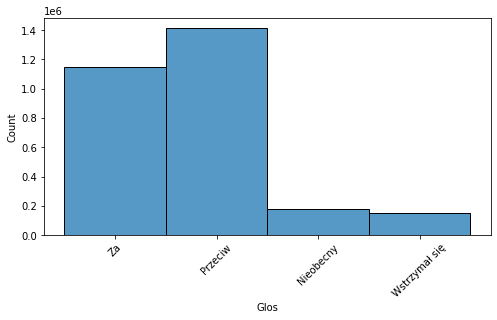

2011-11-08 13:09:45 2015-10-09 10:24:58
2011-11 2015-10


In [55]:
k = 7
xml_file_path = '.\Sejm-20240316T162344Z-001\Sejm\GLO7k1p102p_i\GLO7k1p102p_i.xml'
csv_file = 'data\GLO7k1p102p_i.csv'

df_all = pre.save_xml_as_csv(xml_file_path, csv_file)

display(df_all.head())

assert np.all(df_all.dtypes.values == [np.dtype('int32'), np.dtype('<M8[ns]'), np.dtype('int32'), np.dtype('O'), np.dtype('O'), np.dtype('O')])
assert df_all.isnull().sum().sum() == 0
assert df_all[df_all.duplicated()].size == 0

plt.figure(figsize=(8, 4))
sns.histplot(data=df_all, x='Glos', discrete=True)
plt.xticks(rotation=45)
plt.show()

print(df_all['data_godzina'].min(), df_all['data_godzina'].max())
y_m_list = pd.date_range(df_all['data_godzina'].min(), df_all['data_godzina'].max(), 
              freq='M').strftime("%Y-%m").tolist()

y_m_list.append(df_all['data_godzina'].max().strftime("%Y-%m"))
print(y_m_list[0], y_m_list[-1])
y_m_list = [x.split('-') for x in y_m_list]

# df_deputies = pre.assign_node_ids(df_all)

In [56]:
df_all = df_all.replace({461: 21, 462:127, 459:142, 460:393}) 
df_all = df_all.replace({463:459, 464:460})

df_deputies = pre.create_deputy_df(df_all)
    
vote_ids = sorted(df_all['vote_id'].unique())
deputy_ids_per_vote = [df_all[df_all['vote_id'] == vote_id]['Nrleg'].unique() for vote_id in vote_ids]

removed_ids, new_ids = pre.make_queues(df_deputies, vote_ids, deputy_ids_per_vote)

removed_ids.remove((285, ['RP', 'TR', 'niez.'], 7101001))
removed_ids.remove((27, ['RP', 'TR'], 7083001))


# new_ids.remove((460, ['niez.'], 7001011))
# new_ids.remove((459, ['SP', 'PSL', 'niez.', 'KPSP', 'ZP'], 7001011))
new_ids.remove((517, ['RP'], 7101001))
new_ids.remove((502, ['PiS'], 7083168))

node_id_dict = pre.find_pairs(removed_ids, new_ids)

node_id_dict[517] = 285
node_id_dict[502] = 27
node_id_dict[499] = 336


node_id_dict_func = lambda x: node_id_dict[x]
node_id_dict_func = np.vectorize(node_id_dict_func)

df_deputies['node_id'] = node_id_dict_func(df_deputies['Nrleg'])
df_deputies['node_id'] = df_deputies['node_id'] - 1

In [34]:
for year, month in y_m_list:
    df_m = df_all[(df_all['data_godzina'].dt.month == int(month)) & (df_all['data_godzina'].dt.year == int(year))]
    
    if len(df_m) == 0:
        print(year, month, 'no votings')
        continue
    
    df_m = pd.merge(df_m[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_m)
    df_node_atr.to_csv(f'df_node_atr/monthly/G_{k}_{year}_{month}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_m)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}_{year}_{month}", monthly=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:06<00:00, 13.20it/s]


246 G_7_2013_08


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 12.84it/s]


330 G_7_2014_09


100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:26<00:00,  9.46it/s]


421 G_7_2014_12


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:22<00:00,  9.86it/s]


263 G_7_2015_01


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:06<00:00, 12.40it/s]


In [35]:
df_all = pd.merge(df_all, df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
df_node_atr = pre.assign_attributes(df_all)
df_node_atr.to_csv(f'df_node_atr/G_{k}.csv', index=False)

edge_matrix = pre.egde_weights(df_all)

pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}", monthly=False)

100%|████████████████████████████████████████████████████████████████████████████| 6291/6291 [2:12:28<00:00,  1.26s/it]


In [57]:
start = df_all['data_godzina'].min()
end_1 = pd.date_range(start=df_all['data_godzina'].min(), periods=12, freq='M')[-1]
end_2 = pd.date_range(start=end_1, periods=13, freq='M')[-1]
end_3 = pd.date_range(start=end_2, periods=13, freq='M')[-1]
end_4 = df_all['data_godzina'].max()

start_end_dates = [start, end_1, end_2, end_3, end_4]
print(start_end_dates)

for i in range(1, len(start_end_dates)):
    start_dt = start_end_dates[i-1]
    end_dt = start_end_dates[i]
    df_y = df_all[(df_all['data_godzina'] >= start_dt) & (df_all['data_godzina'] < end_dt)]
    
    df_y = pd.merge(df_y[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_y)
    df_node_atr.to_csv(f'df_node_atr/yearly/G_{k}_y{i}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_y)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"yearly/G_{k}_y{i}", monthly=False)

[Timestamp('2011-11-08 13:09:45'), Timestamp('2012-10-31 13:09:45', freq='M'), Timestamp('2013-10-31 13:09:45', freq='M'), Timestamp('2014-10-31 13:09:45', freq='M'), Timestamp('2015-10-09 10:24:58')]


100%|██████████████████████████████████████████████████████████████████████████████| 2271/2271 [17:17<00:00,  2.19it/s]


## 8th term: 2015 - 2019

,vote_id,data_godzina,Nrleg,NazwiskoImie,Glos,Klub
0,8001002,2015-11-12 18:18:06,1,Abramowicz Adam,Przeciw,PiS
1,8001002,2015-11-12 18:18:06,2,Adamczyk Andrzej,Przeciw,PiS
2,8001002,2015-11-12 18:18:06,3,Ajchler Zbigniew,Nieobecny,PO
3,8001002,2015-11-12 18:18:06,4,Andruszkiewicz Adam,Wstrzymał się,Kukiz15
4,8001002,2015-11-12 18:18:06,5,Andzel Waldemar,Przeciw,PiS


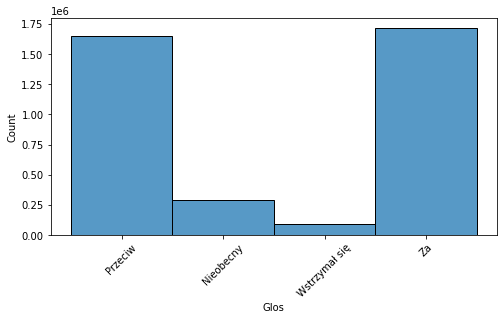

2015-11-12 18:18:06 2019-10-16 18:37:05
2015-11 2019-10


In [58]:
k = 8
xml_file_path = '.\Sejm-20240316T162344Z-001\Sejm\GLO8k1p86p_i\GLO8k1p86p_i.xml'
csv_file = 'data\GLO8k1p86p_i.csv'

df_all = pre.save_xml_as_csv(xml_file_path, csv_file)

display(df_all.head())

assert np.all(df_all.dtypes.values == [np.dtype('int32'), np.dtype('<M8[ns]'), np.dtype('int32'), np.dtype('O'), np.dtype('O'), np.dtype('O')])
assert df_all.isnull().sum().sum() == 0
assert df_all[df_all.duplicated()].size == 0

plt.figure(figsize=(8, 4))
sns.histplot(data=df_all, x='Glos', discrete=True)
plt.xticks(rotation=45)
plt.show()

print(df_all['data_godzina'].min(), df_all['data_godzina'].max())
y_m_list = pd.date_range(df_all['data_godzina'].min(), df_all['data_godzina'].max(), 
              freq='M').strftime("%Y-%m").tolist()

y_m_list.append(df_all['data_godzina'].max().strftime("%Y-%m"))
print(y_m_list[0], y_m_list[-1])
y_m_list = [x.split('-') for x in y_m_list]

In [59]:
df_all = df_all.replace({461:202})
df_deputies = pre.create_deputy_df(df_all)
    
vote_ids = sorted(df_all['vote_id'].unique())
deputy_ids_per_vote = [df_all[df_all['vote_id'] == vote_id]['Nrleg'].unique() for vote_id in vote_ids]

removed_ids, new_ids = pre.make_queues(df_deputies, vote_ids, deputy_ids_per_vote)

removed_ids.remove((436, ['Kukiz15'], 8034001))
removed_ids.remove((19, ['Kukiz15'], 8071001))
removed_ids.remove((169, ['PO', 'PO-KO'], 8082001))
removed_ids.remove((259, ['PSL', 'niez.', 'PiS'], 8082001))


new_ids.remove((471, ['niez.', 'Republikanie', 'PiS'], 8035001))
new_ids.remove((478, ['niez.', 'Konfederacja'], 8072001))
new_ids.remove((493, ['niez.', 'PSL-UED', 'PSL-KP'], 8082001))
new_ids.remove((500, ['PSL-UED', 'PSL-KP'], 8082001))

node_id_dict = pre.find_pairs(removed_ids, new_ids)

node_id_dict[471] = 436
node_id_dict[478] = 19
node_id_dict[493] = 169
node_id_dict[500] = 259
node_id_dict[476] = 460


node_id_dict_func = lambda x: node_id_dict[x]
node_id_dict_func = np.vectorize(node_id_dict_func)

df_deputies['node_id'] = node_id_dict_func(df_deputies['Nrleg'])
df_deputies['node_id'] = df_deputies['node_id'] - 1

In [5]:
for year, month in y_m_list:
    df_m = df_all[(df_all['data_godzina'].dt.month == int(month)) & (df_all['data_godzina'].dt.year == int(year))]
    
    if len(df_m) == 0:
        print(year, month, 'no votings')
        continue
    
    df_m = pd.merge(df_m[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_m)
    df_node_atr.to_csv(f'df_node_atr/monthly/G_{k}_{year}_{month}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_m)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}_{year}_{month}", monthly=True)

100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:19<00:00, 11.43it/s]


2016 08 no votings


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.75it/s]


434 G_8_2017_01


100%|████████████████████████████████████████████████████████████████████████████████| 358/358 [00:33<00:00, 10.81it/s]


2017 08 no votings


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [01:03<00:00,  8.06it/s]


2018 08 no votings


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:16<00:00, 11.82it/s]


405 G_8_2018_11


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:09<00:00, 13.50it/s]


117 G_8_2019_06


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 13.74it/s]


388 G_8_2019_10


In [6]:
df_all = pd.merge(df_all, df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
df_node_atr = pre.assign_attributes(df_all)
df_node_atr.to_csv(f'df_node_atr/G_{k}.csv', index=False)

edge_matrix = pre.egde_weights(df_all)

pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}", monthly=False)

100%|████████████████████████████████████████████████████████████████████████████| 8154/8154 [2:23:40<00:00,  1.06s/it]


In [60]:
start = df_all['data_godzina'].min()
end_1 = pd.date_range(start=df_all['data_godzina'].min(), periods=12, freq='M')[-1]
end_2 = pd.date_range(start=end_1, periods=13, freq='M')[-1]
end_3 = pd.date_range(start=end_2, periods=13, freq='M')[-1]
end_4 = df_all['data_godzina'].max()

start_end_dates = [start, end_1, end_2, end_3, end_4]
print(start_end_dates)

for i in range(1, len(start_end_dates)):
    start_dt = start_end_dates[i-1]
    end_dt = start_end_dates[i]
    df_y = df_all[(df_all['data_godzina'] >= start_dt) & (df_all['data_godzina'] < end_dt)]
    
    df_y = pd.merge(df_y[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_y)
    df_node_atr.to_csv(f'df_node_atr/yearly/G_{k}_y{i}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_y)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"yearly/G_{k}_y{i}", monthly=False)

[Timestamp('2015-11-12 18:18:06'), Timestamp('2016-10-31 18:18:06', freq='M'), Timestamp('2017-10-31 18:18:06', freq='M'), Timestamp('2018-10-31 18:18:06', freq='M'), Timestamp('2019-10-16 18:37:05')]


100%|██████████████████████████████████████████████████████████████████████████████| 1884/1884 [11:23<00:00,  2.76it/s]


## 9th term: 2021 - 2023

In [61]:
k = 9
df_all = pd.read_csv('data/API/GLO9k1p81p_i.csv')
df_all['NazwiskoImie'] = df_all['lastName'] + ' ' + df_all['firstName']

df_all = df_all.rename(columns={"date": "data_godzina",
                                "vote": "Glos",
                                "club": "Klub",
                                "MP": "Nrleg"                               
                               })

df_all['Nrleg'] = df_all['Nrleg'].astype(int)
df_all['Glos'] = df_all['Glos'].map({'YES': 'Za', 
                                     'NO': 'Przeciw',
                                     'ABSTAIN': 'Wstrzymał się',
                                     'ABSENT': 'Nieobecny'
                                    })

df_all.head()

,data_godzina,term,sitting,votingNumber,Nrleg,Klub,firstName,lastName,Glos,vote_id,NazwiskoImie
0,2019-11-12 15:26:06,9,1,1,1,PiS,Andrzej,Adamczyk,Za,9001001,Adamczyk Andrzej
1,2019-11-12 15:26:06,9,1,1,2,SLD,Rafał,Adamczyk,Za,9001001,Adamczyk Rafał
2,2019-11-12 15:26:06,9,1,1,3,KO,Piotr,Adamowicz,Wstrzymał się,9001001,Adamowicz Piotr
3,2019-11-12 15:26:06,9,1,1,4,SLD,Romuald,Ajchler,Za,9001001,Ajchler Romuald
4,2019-11-12 15:26:06,9,1,1,5,PiS,Adam,Andruszkiewicz,Za,9001001,Andruszkiewicz Adam


In [62]:
df_all = df_all.astype({'data_godzina': 'datetime64[ns]'})
df_all.dtypes

data_godzina    datetime64[ns]
term                     int64
sitting                  int64
votingNumber             int64
Nrleg                    int32
Klub                    object
firstName               object
lastName                object
Glos                    object
vote_id                  int64
NazwiskoImie            object
dtype: object

In [63]:
df_all = df_all[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']]
df_all = df_all.sort_values(['vote_id', 'Nrleg'])

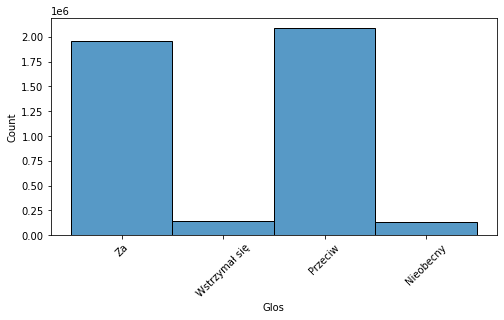

2019-11-12 15:26:06 2023-08-30 19:15:03
2019-11 2023-08


In [64]:
assert df_all.isnull().sum().sum() == 0
assert df_all[df_all.duplicated()].size == 0

plt.figure(figsize=(8, 4))
sns.histplot(data=df_all, x='Glos', discrete=True)
plt.xticks(rotation=45)
plt.show()

print(df_all['data_godzina'].min(), df_all['data_godzina'].max())
y_m_list = pd.date_range(df_all['data_godzina'].min(), df_all['data_godzina'].max(), 
              freq='M').strftime("%Y-%m").tolist()

y_m_list.append(df_all['data_godzina'].max().strftime("%Y-%m"))
print(y_m_list[0], y_m_list[-1])
y_m_list = [x.split('-') for x in y_m_list]

In [65]:
df_all = df_all.drop(df_all[df_all['vote_id'] == 9001053].index)
df_all = df_all.drop(df_all[df_all['vote_id'] == 9047126].index)
df_all = df_all.drop(df_all[df_all['vote_id'] == 9031018].index)
df_all = df_all.drop(df_all[df_all['vote_id'] == 9034001].index)
df_all = df_all.drop(df_all[df_all['vote_id'] == 9061141].index)
df_all = df_all.drop(df_all[df_all['vote_id'] == 9063060].index)

In [66]:
df_all.to_csv('data/GLO9k1p81p_i.csv', index=False)

In [67]:
df_deputies = pre.create_deputy_df(df_all)
    
vote_ids = sorted(df_all['vote_id'].unique())
deputy_ids_per_vote = [df_all[df_all['vote_id'] == vote_id]['Nrleg'].unique() for vote_id in vote_ids]

In [68]:
removed_ids, new_ids = pre.make_queues(df_deputies, vote_ids, deputy_ids_per_vote)

removed_ids.remove((81, ['PSL', 'PSL-Kukiz15', 'KP'], 9025001))
removed_ids.remove((258, ['KO'], 9031001))

new_ids.remove((466, ['niez.'], 9027001))
new_ids.remove((469, ['niez.'], 9031001))

node_id_dict = pre.find_pairs(removed_ids, new_ids)

node_id_dict[466] = 81
node_id_dict[469] = 258

node_id_dict_func = lambda x: node_id_dict[x]
node_id_dict_func = np.vectorize(node_id_dict_func)

df_deputies['node_id'] = node_id_dict_func(df_deputies['Nrleg'])
df_deputies['node_id'] = df_deputies['node_id'] - 1

In [121]:
for year, month in y_m_list:
    df_m = df_all[(df_all['data_godzina'].dt.month == int(month)) & (df_all['data_godzina'].dt.year == int(year))]
    
    if len(df_m) == 0:
        print(year, month, 'no votings')
        continue
    
    df_m = pd.merge(df_m[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_m)
    df_node_atr.to_csv(f'df_node_atr/monthly/G_{k}_{year}_{month}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_m)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}_{year}_{month}", monthly=True)

100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:15<00:00, 13.14it/s]


79 G_9_2021_01


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:06<00:00, 15.02it/s]


79 G_9_2021_02


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:12<00:00, 14.21it/s]


413 G_9_2021_04


100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:14<00:00, 12.76it/s]


In [10]:
df_all = pd.merge(df_all, df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
df_node_atr = pre.assign_attributes(df_all)
df_node_atr.to_csv(f'df_node_atr/G_{k}.csv', index=False)

edge_matrix = pre.egde_weights(df_all)

pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}", monthly=False)

100%|████████████████████████████████████████████████████████████████████████████| 9383/9383 [3:36:25<00:00,  1.38s/it]


In [69]:
start = df_all['data_godzina'].min()
end_1 = pd.date_range(start=df_all['data_godzina'].min(), periods=12, freq='M')[-1]
end_2 = pd.date_range(start=end_1, periods=13, freq='M')[-1]
end_3 = pd.date_range(start=end_2, periods=13, freq='M')[-1]
end_4 = df_all['data_godzina'].max()

start_end_dates = [start, end_1, end_2, end_3, end_4]
print(start_end_dates)

for i in range(1, len(start_end_dates)):
    start_dt = start_end_dates[i-1]
    end_dt = start_end_dates[i]
    df_y = df_all[(df_all['data_godzina'] >= start_dt) & (df_all['data_godzina'] < end_dt)]
    
    df_y = pd.merge(df_y[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_y)
    df_node_atr.to_csv(f'df_node_atr/yearly/G_{k}_y{i}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_y)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"yearly/G_{k}_y{i}", monthly=False)

[Timestamp('2019-11-12 15:26:06'), Timestamp('2020-10-31 15:26:06', freq='M'), Timestamp('2021-10-31 15:26:06', freq='M'), Timestamp('2022-10-31 15:26:06', freq='M'), Timestamp('2023-08-30 19:15:03')]


100%|██████████████████████████████████████████████████████████████████████████████| 2316/2316 [09:26<00:00,  4.09it/s]


## 10th term: 2023 - 2024 April

,data_godzina,term,sitting,votingNumber,Nrleg,Klub,firstName,lastName,Glos,vote_id,NazwiskoImie
0,2023-11-13 15:17:22,10,1,1,234,PiS,Dariusz,Matecki,Nieobecny,10001001,Matecki Dariusz
1,2023-11-13 18:02:12,10,1,2,1,PiS,Andrzej,Adamczyk,Za,10001002,Adamczyk Andrzej
2,2023-11-13 18:02:12,10,1,2,2,KO,Piotr,Adamowicz,Za,10001002,Adamowicz Piotr
3,2023-11-13 18:02:12,10,1,2,3,PiS,Adam,Andruszkiewicz,Za,10001002,Andruszkiewicz Adam
4,2023-11-13 18:02:12,10,1,2,4,PiS,Waldemar,Andzel,Za,10001002,Andzel Waldemar


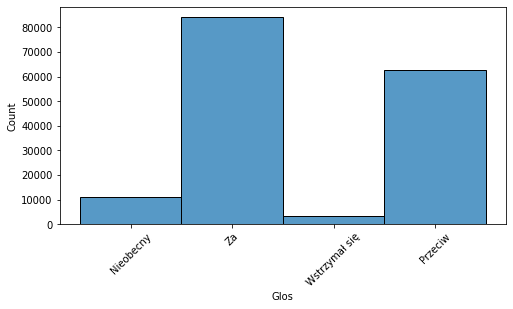

2023-11-13 15:17:22 2024-04-26 11:30:28
2023-11 2024-04


In [11]:
k = 10
df_all = pd.read_csv('data/API/GLO10k1p10p_i.csv')
df_all['NazwiskoImie'] = df_all['lastName'] + ' ' + df_all['firstName']

df_all = df_all.rename(columns={"date": "data_godzina",
                                "vote": "Glos",
                                "club": "Klub",
                                "MP": "Nrleg"                               
                               })

df_all['Nrleg'] = df_all['Nrleg'].astype(int)
df_all['Glos'] = df_all['Glos'].map({'YES': 'Za', 
                                     'NO': 'Przeciw',
                                     'ABSTAIN': 'Wstrzymał się',
                                     'ABSENT': 'Nieobecny'
                                    })

display(df_all.head())

df_all = df_all.astype({'data_godzina': 'datetime64[ns]'})

df_all = df_all[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']]
df_all = df_all.sort_values(['vote_id', 'Nrleg'])

assert df_all.isnull().sum().sum() == 0
assert df_all[df_all.duplicated()].size == 0

plt.figure(figsize=(8, 4))
sns.histplot(data=df_all, x='Glos', discrete=True)
plt.xticks(rotation=45)
plt.show()

print(df_all['data_godzina'].min(), df_all['data_godzina'].max())
y_m_list = pd.date_range(df_all['data_godzina'].min(), df_all['data_godzina'].max(), 
              freq='ME').strftime("%Y-%m").tolist()

y_m_list.append(df_all['data_godzina'].max().strftime("%Y-%m"))
print(y_m_list[0], y_m_list[-1])
y_m_list = [x.split('-') for x in y_m_list]

In [12]:
df_all = df_all.drop(df_all[df_all['vote_id'] == 10001001].index)
df_all = df_all.drop(df_all[df_all['vote_id'] == 10001013].index)
df_all = df_all.drop(df_all[df_all['vote_id'] == 10002011].index)

In [13]:
df_all.to_csv('data/GLO10k1p10p_i.csv', index=False)

In [14]:
df_deputies = pre.create_deputy_df(df_all)
    
vote_ids = sorted(df_all['vote_id'].unique())
deputy_ids_per_vote = [df_all[df_all['vote_id'] == vote_id]['Nrleg'].unique() for vote_id in vote_ids]

In [15]:
removed_ids, new_ids = pre.make_queues(df_deputies, vote_ids, deputy_ids_per_vote)

removed_ids.remove((152, ['PiS'], 10002001))

new_ids.remove((463, ['niez.'], 10007001))

node_id_dict = pre.find_pairs(removed_ids, new_ids)

node_id_dict[463] = 152

node_id_dict_func = lambda x: node_id_dict[x]
node_id_dict_func = np.vectorize(node_id_dict_func)

df_deputies['node_id'] = node_id_dict_func(df_deputies['Nrleg'])
df_deputies['node_id'] = df_deputies['node_id'] - 1

In [162]:
for year, month in y_m_list:
    df_m = df_all[(df_all['data_godzina'].dt.month == int(month)) & (df_all['data_godzina'].dt.year == int(year))]
    
    if len(df_m) == 0:
        print(year, month, 'no votings')
        continue
    
    df_m = pd.merge(df_m[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
    df_node_atr = pre.assign_attributes(df_m)
    df_node_atr.to_csv(f'df_node_atr/monthly/G_{k}_{year}_{month}.csv', index=False)
    
    edge_matrix = pre.egde_weights(df_m)
    
    G = pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}_{year}_{month}", monthly=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.63it/s]


150 G_10_2024_01
411 G_10_2024_01


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 13.55it/s]


150 G_10_2024_02
411 G_10_2024_02


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.68it/s]


411 G_10_2024_03


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:04<00:00, 13.85it/s]


411 G_10_2024_04


In [16]:
df_all = pd.merge(df_all, df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')
df_node_atr = pre.assign_attributes(df_all)
df_node_atr.to_csv(f'df_node_atr/G_{k}.csv', index=False)

edge_matrix = pre.egde_weights(df_all)

pre.create_graph(edge_matrix, df_node_atr, file_name=f"G_{k}", monthly=False)

100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [00:36<00:00,  9.54it/s]
